In [ ]:
# Copyright © 2025 Amlan Chatterjee. All rights reserved.

"""
RADAR FUNDAMENTALS & SIMULATOR - Part 2
========================================
Doppler Processing & Range-Doppler Maps

Target: Build complete RDM generation pipeline
Timeline: Weekend 1 (Oct 5-6) continuation

Prerequisites: Complete Part 1 (Range-FFT understanding)
"""

'\nRADAR FUNDAMENTALS & SIMULATOR - Part 2\n========================================\nDoppler Processing & Range-Doppler Maps\n\nTarget: Build complete RDM generation pipeline\nTimeline: Weekend 1 (Oct 5-6) continuation\n\nPrerequisites: Complete Part 1 (Range-FFT understanding)\n'

In [2]:
# Standard imports
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
from scipy.fft import fft, fft2, fftshift, fftfreq
import warnings
warnings.filterwarnings('ignore')

# Visualization setup
plt.rcParams['figure.figsize'] = (14, 8)
plt.rcParams['font.size'] = 10

---
# Part 2: Doppler Processing & Range-Doppler Maps

## Recap from Part 1

You now understand:
- ✅ Range-FFT: Time samples → Range bins (single pulse)
- ✅ I/Q signals preserve phase information
- ✅ Radar parameters: PRF, bandwidth, resolution

## What's Next

A **single pulse** gives you range. But to get **velocity**, you need:
- Multiple coherent pulses (same phase reference)
- Doppler-FFT across pulses
- The result: **Range-Doppler Map (RDM)** - a 2D image showing everything

---
# 1. Why We Need Doppler: The Moving Target Problem

## The Challenge

Imagine a stationary clutter (building) at 1000m and a moving drone also at 1000m.
- **Range-FFT alone:** Both show up in the same range bin - indistinguishable!
- **Solution:** Use Doppler frequency to separate them

## Doppler Shift Physics

**Moving target causes frequency shift:**
```
f_doppler = 2 * v_radial / λ

Where:
- v_radial = velocity toward radar (positive) or away (negative) [m/s]
- λ = wavelength [m]

Example: v = 50 m/s, λ = 0.03 m (10 GHz)
f_doppler = 2 * 50 / 0.03 = 3,333 Hz
```

**Why the factor of 2?**
- Signal travels TO target (Doppler shift × 1)
- Reflects back FROM target (Doppler shift × 1 again)
- Total: 2× the shift

## How Doppler Appears in Pulse-Doppler Radar

**Key insight:**
- Pulse 1: Target at range R → echo has phase φ₁
- Pulse 2: Target moved → echo has phase φ₂ = φ₁ + Δφ
- Pulse 3: Target moved more → echo has phase φ₃ = φ₁ + 2Δφ
- ...

**Phase change between pulses:**
```
Δφ = 2π * f_doppler * PRI
   = 4π * v_radial * PRI / λ
```

**This phase progression IS the Doppler signature!**
- Stationary target: φ stays constant across pulses
- Moving target: φ changes linearly across pulses
- FFT across pulses → frequency → velocity

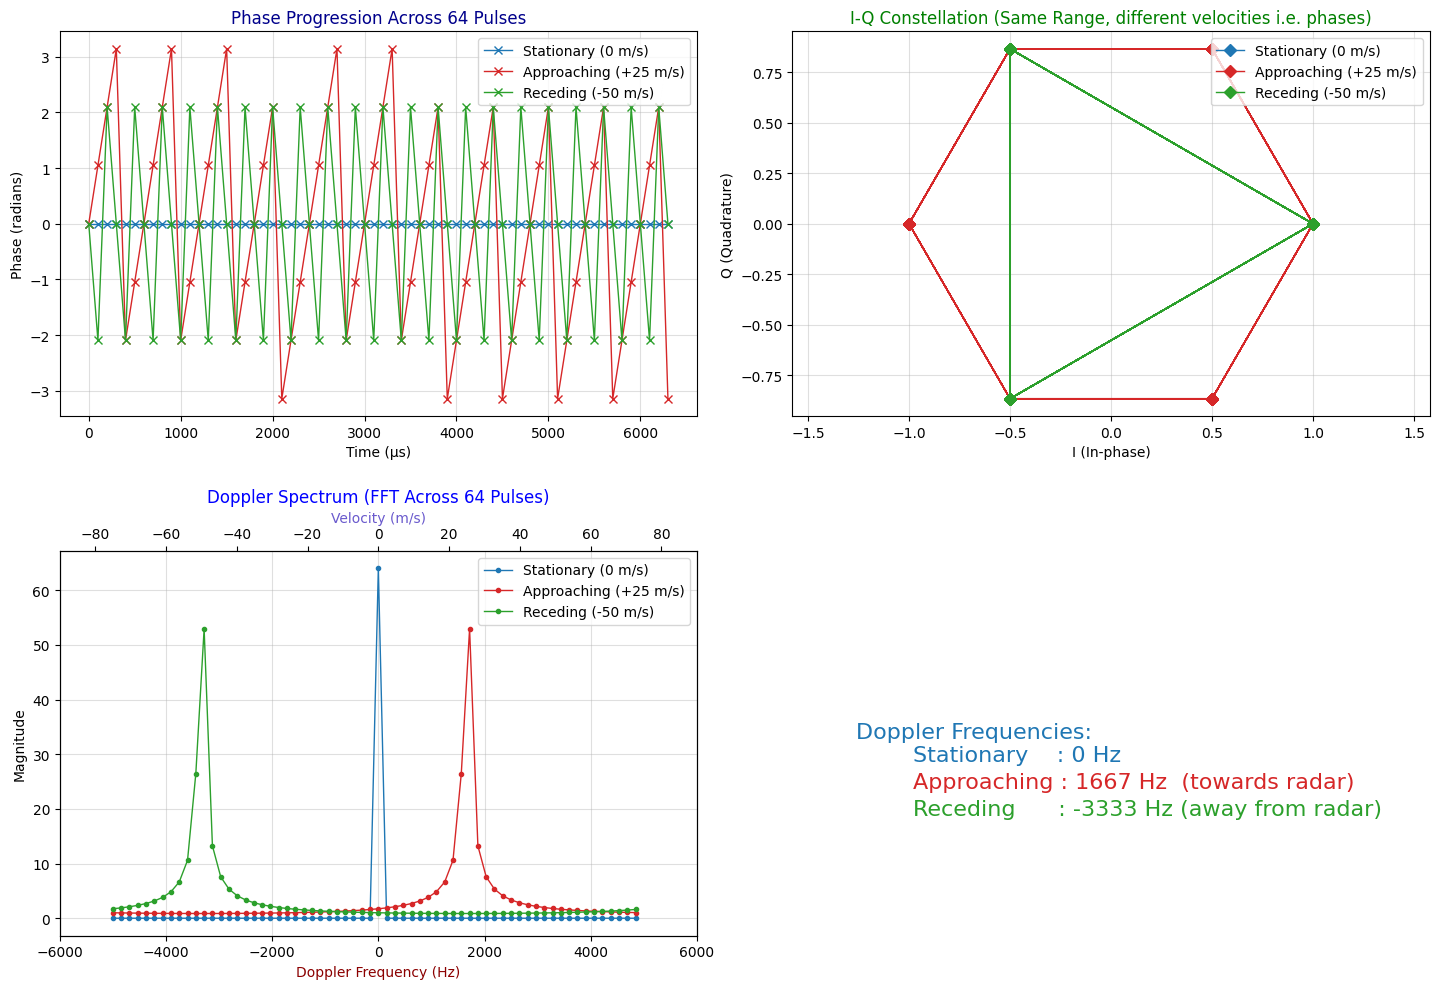

In [3]:
def visualize_doppler_concept():
    """
    Demonstrate how Doppler appears as phase change across pulses
    """
    # Parameters
    num_pulses = 64
    PRI = 100e-6  # 100 μs (10 kHz PRF)
    wavelength = 0.03  # 3 cm (10 GHz)

    # Three targets at same range, different velocities
    velocities = [0, 25, -50]  # m/s (stationary, approaching, receding)
    colors = ['C0', 'C3', 'C2']
    labels = ['Stationary (0 m/s)', 'Approaching (+25 m/s)', 'Receding (-50 m/s)']
    #
    pulse_times = np.arange(num_pulses) * PRI
    fig, axes = plt.subplots(2, 2, figsize=(15, 10), linewidth=0.1)
    #
    #
    for v, color, label in zip(velocities, colors, labels):
        # Doppler frequency
        f_d = 2 * v / wavelength

        # Phase progression across pulses
        phase = 2 * np.pi * f_d * pulse_times

        # Complex signal at each pulse (same range bin)
        signal = np.exp(1j * phase)

        # Plot phase progression
        axes[0, 0].plot(pulse_times * 1e6, np.angle(signal), marker='x', label=label, color=color, linewidth=1)

        # Plot I/Q constellation
        axes[0, 1].plot(signal.real, signal.imag, marker='D', label=label, color=color, linewidth=1)

        # FFT to get Doppler spectrum
        spectrum = fftshift(fft(signal))

        # To display with centers of each bin
        freqs = fftshift(fftfreq(num_pulses, PRI))
        axes[1, 0].plot(freqs, np.abs(spectrum), marker='.', label=label, color=color, linewidth=1)

    # Formatting
    axes[0, 0].set_xlabel('Time (μs)')
    axes[0, 0].set_ylabel('Phase (radians)')
    axes[0, 0].set_title(f"Phase Progression Across {num_pulses} Pulses", color="darkblue")
    axes[0, 0].legend(loc='best')
    axes[0, 0].grid(True, alpha=0.4)

    axes[0, 1].set_xlabel('I (In-phase)')
    axes[0, 1].set_ylabel('Q (Quadrature)')
    axes[0, 1].set_title('I-Q Constellation (Same Range, different velocities i.e. phases)', color='Green')
    axes[0, 1].legend(loc='upper right')
    axes[0, 1].grid(True, alpha=0.4)
    axes[0, 1].axis('equal')

    axes[1, 0].set_xlabel('Doppler Frequency (Hz)', color='darkred')
    axes[1, 0].set_ylabel('Magnitude')
    axes[1, 0].set_title(f"Doppler Spectrum (FFT Across {num_pulses} Pulses)", color='Blue')
    axes[1, 0].set_xlim([-6000, 6000])
    axes[1, 0].grid(True, alpha=0.4)
    axes[1, 0].legend(loc='best')


    # Convert Doppler freq to velocity for second x-axis
    ax2 = axes[1, 0].twiny()

    # Set the second X axis above with common y axis
    ax2.text(0, 0, '', family='cursive')
    ax2.set_xlim(np.array(axes[1, 0].get_xlim()) * wavelength / 2)
    ax2.set_xlabel('Velocity (m/s)', color='slateblue')

    # Summary text
    summary1 = f"""Doppler Frequencies:
        Stationary    : {2*velocities[0]/wavelength:.0f} Hz"""
    summary2 = f"""        Approaching : {2*velocities[1]/wavelength:.0f} Hz  (towards radar)"""
    summary3 = f"""        Receding      : {2*velocities[2]/wavelength:.0f} Hz (away from radar)"""

    axes[1, 1].text(0.1, 0.5, summary1, fontsize=16, family='sans-serif', verticalalignment='center', color='C0')
    axes[1, 1].text(0.1, 0.4, summary2, fontsize=16, family='sans-serif', verticalalignment='center', color='C3')
    axes[1, 1].text(0.1, 0.33, summary3, fontsize=16, family='sans-serif', verticalalignment='center', color='C2')
    axes[1, 1].axis('off')

    plt.tight_layout()
    plt.subplots_adjust(wspace=0.15, hspace=0.35)
    # plt.savefig('/tmp/doppler_concept.png', dpi=150, bbox_inches='tight')
    plt.show()

# Uncomment to run:
visualize_doppler_concept()

---
# 2. The Range-Doppler Map (RDM): Bringing It All Together

## The Core Idea: Why We Need 2D Processing

**Think back to basics:**
- **One pulse** → Process its samples → Get range (via time delay)
- **Multiple pulses** → Compare phase changes → Get velocity (via Doppler)

**The challenge:** A target has BOTH range AND velocity. How do we measure both simultaneously?

**The solution:** Organize data into a 2D matrix and process in two dimensions.

---

## How Pulse-Doppler Radar Collects Data

**Physical picture:**

Imagine you're transmitting 128 pulses, one every 100 μs (your PRI). Each pulse travels out, hits targets, and returns. You digitize each echo into 256 samples.

**What you end up with:**
```
Pulse 1:  [sample_0, sample_1, sample_2, ..., sample_255]  ← 256 range samples
Pulse 2:  [sample_0, sample_1, sample_2, ..., sample_255]
Pulse 3:  [sample_0, sample_1, sample_2, ..., sample_255]
...
Pulse 128: [sample_0, sample_1, sample_2, ..., sample_255]
```

**This creates a 2D data matrix: [128 pulses × 256 samples]**

---

## Understanding the Two Time Scales

**Fast-time (horizontal, within one pulse):**
- Time within a single pulse as it's being sampled
- Samples 0→255 happen in ~10 μs (your pulse duration)
- This encodes **range** (because time = distance / c)

**Slow-time (vertical, across pulses):**
- Time from pulse to pulse
- Pulses 0→127 span 12.8 ms (your **CPI** duration i.e. Observation Window)
- This encodes **velocity** (because phase changes between pulses)

**Analogy:** Think of a music spectrogram
- Horizontal axis = time within each analysis window (like fast-time)
- Vertical axis = frequency bins showing how spectrum changes over time (like slow-time)
- RDM is similar: fast-time → range, slow-time → velocity

---

## Two-Stage Processing: Building the RDM

### Step 1: Range-FFT (Process Each Pulse Individually)

**What we do:**
```
For each pulse (each row):
    Take FFT across the 256 samples → Get 256 range bins
```

**What this reveals:**
- Converts time-domain samples → frequency-domain range bins
- Each pulse now shows "what's at what range"
- BUT we still have 128 pulses, so we have 128 copies of "range profile"

**After Step 1:** Matrix is now [128 pulses × 256 range bins]

### Step 2: Doppler-FFT (Process Across Pulses)

**What we do:**
```
For each range bin (each column):
    Take FFT across the 128 pulses → Get 128 Doppler bins
```

**What this reveals:**
- At range bin k, how did the signal change from pulse to pulse?
- Stationary target: no phase change → DC (zero Doppler)
- Moving target: linear phase change → frequency offset (Doppler shift)

**After Step 2:** Matrix is now [128 Doppler bins × 256 range bins] = **RDM**

---

## Visual Processing Flow

```
Raw I/Q Data Matrix               After Range-FFT                After Doppler-FFT
[128 pulses × 256 samples]  →  [128 pulses × 256 range bins]  →  [128 Doppler × 256 range]
      
  Time samples                     Range information              Range-Doppler Map (RDM)
  per pulse                        per pulse                      
                                                                  X-axis: Range
                                                                  Y-axis: Velocity
```

**Shortcut notation:**
```
RDM = FFT2D(raw_data_matrix)
```
This is mathematically equivalent to doing Range-FFT then Doppler-FFT.

---

## The Math Behind It (Now That You Understand the Concept)

### Signal Model

**For a single target at range R and velocity v:**

```
s[m, n] = A · exp(j · 2π · (f_range · n/f_sampling + f_doppler · m · PRI))

Where:
m = pulse index (0 to 127)          ← slow-time index
n = sample index (0 to 255)         ← fast-time index
f_range = 2·R·B/c                   ← range frequency (from round-trip delay)
f_doppler = 2·v/λ                   ← Doppler frequency (from motion)
```

**Key insight:** This is a 2D sinusoid!
- Oscillates in n-direction (fast-time) at frequency f_range
- Oscillates in m-direction (slow-time) at frequency f_doppler
- 2D FFT finds these two frequencies → gives you R and v

### After 2D FFT

```
RDM[doppler_bin, range_bin] = |FFT2D(s[m,n])|²

The target appears as a bright peak at:
- range_bin corresponding to its distance
- doppler_bin corresponding to its velocity
```

---

## Converting Bins to Physical Units

### Range Axis (X-axis)

Each range bin k corresponds to:
```
Range[k] = k · c / (2 · B)

Example: B = 150 MHz, k = 100
Range = 100 · (3×10⁸) / (2 · 150×10⁶) = 100 m
```

**Why?** Frequency bin spacing = B/N, and range = c·Δt/2 = c·Δf/(2·B)

### Velocity Axis (Y-axis)

Each Doppler bin m corresponds to:
```
Velocity[m] = (m - M/2) · λ · PRF / (2 · M)

Where:
- M = number of pulses (128)
- (m - M/2) shifts zero velocity to center
- PRF = 1/PRI (pulse repetition frequency)

Example: λ = 3 cm, PRF = 10 kHz, M = 128, m = 80
Velocity = (80 - 64) · 0.03 · 10000 / (2 · 128) = 18.75 m/s (approaching)
```

**Why?** Doppler bin spacing = PRF/M, and velocity = f_doppler · λ/2

---

## Quick Reality Check

**What you should now understand:**
1. ✅ Why we need a 2D matrix (two parameters: range and velocity)
2. ✅ What fast-time and slow-time mean physically
3. ✅ Why Range-FFT first (process each pulse → get range)
4. ✅ Why Doppler-FFT second (compare pulses → get velocity)
5. ✅ How bins map to real-world range and velocity

**Next section shows you actual RDM images and what to look for!**

In [18]:
class PulseDopplerRadar:
    """
    Complete pulse-Doppler radar simulator with RDM generation
    """

    def __init__(self, f_c=10e9, PRF=10e3, bandwidth=150e6,
                 num_pulses=128, samples_per_pulse=512):
        """
        Parameters:
        - f_c: Carrier frequency (Hz)
        - PRF: Pulse Repetition Frequency (Hz)
        - bandwidth: Signal bandwidth (Hz)
        - num_pulses: Number of coherent pulses (CPI length)
        - samples_per_pulse: Samples in each pulse
        """
        self.f_c = f_c
        self.PRF = PRF
        self.B = bandwidth # half of sampling rate
        self.M = num_pulses  # Slow-time dimension
        self.N = samples_per_pulse  # Fast-time dimension

        # Derived parameters
        self.c = 3e8           # Approx. speed of light
        self.wavelength = self.c / self.f_c
        self.PRI = 1 / self.PRF
        self.f_s = 2 * self.B  # Sampling rate
        self.tau = 1e-6        # Pulse width (1 μs)

        # Axes
        self.range_axis = np.arange(self.N) * self.c / (2 * self.f_s)
        self.time_fast = np.arange(self.N) / self.f_s
        self.time_slow = np.arange(self.M) * self.PRI

        # Doppler "axis" (centered at zero velocity)
        doppler_bins = np.arange(self.M) - self.M // 2
        self.velocity_axis = doppler_bins * self.wavelength * self.PRF / (2 * self.M)

        # Initialize data matrix
        self.data_matrix = np.zeros((self.M, self.N), dtype=complex)


    # Approach 1
    def add_target(self, range_m, velocity_ms, rcs=1.0):
        """
        Add a point target - Simple pulse model with pulse width
        """
        time_delay = 2 * range_m / self.c
        range_sample = int(time_delay * self.f_s)
        #
        if range_sample >= self.N:
            print(f"WARNING: Target at {range_m}m is beyond listening window")
            return
        #
        f_doppler = 2 * velocity_ms / self.wavelength
        #
        # Add pulse with width
        pulse_width_samples = 400  # Change from 200 to 400
        #
        for m in range(self.M):
            phase = -4 * np.pi * range_m / self.wavelength + 2 * np.pi * f_doppler * m * self.PRI
            # Add to multiple samples
            for offset in range(-pulse_width_samples//2, pulse_width_samples//2):
                idx = range_sample + offset
                if 0 <= idx < self.N:
                    self.data_matrix[m, idx] += rcs * 1000.0 * np.exp(1j * phase)


    def generate_rdm(self, window='hamming'):
        """
        Generate RDM - Simple pulse model (only Doppler FFT)
        """
        if window == 'hamming':
            window_doppler = np.hamming(self.M)[:, np.newaxis]
            data_windowed = self.data_matrix * window_doppler
        else:
            data_windowed = self.data_matrix

        # Only Doppler-FFT (axis 0)
        rdm = fft(data_windowed, axis=0)
        rdm = fftshift(rdm, axes=0)

        return np.abs(rdm), self.range_axis, self.velocity_axis



    def add_noise(self, snr_db=20):
        """Add white Gaussian noise"""
        signal_power = np.mean(np.abs(self.data_matrix)**2)
        noise_power = signal_power / (10**(snr_db/10))
        noise = np.sqrt(noise_power/2) * (np.random.randn(self.M, self.N) + 1j * np.random.randn(self.M, self.N))
        self.data_matrix += noise


    # Modified below
    def plot_rdm(self, rdm, range_axis, velocity_axis,
             range_max_km=10, dynamic_range_db=60):
        """
        Visualize the Range-Doppler Map
        """
        # Convert to dB scale
        rdm_db = 20 * np.log10(rdm + 1e-10)
        rdm_db -= np.max(rdm_db)  # Normalize to peak

        # Plot
        fig, ax = plt.subplots(figsize=(14, 8))

        # Use only valid range bins
        range_bins = range_axis < range_max_km * 1000

        im = ax.imshow(
            rdm_db[:, range_bins],
            aspect='auto',
            extent=[0, range_max_km, velocity_axis[0], velocity_axis[-1]],
            cmap='jet',
            vmin = -dynamic_range_db,
            vmax = 0,
            origin = 'lower',
            interpolation='nearest'  # ADD THIS - no smoothing
        )

        ax.set_xlabel('Range (km)', fontsize=12)
        ax.set_ylabel('Velocity (m/s)', fontsize=12)
        ax.set_title('Range-Doppler Map (RDM)', fontsize=14, fontweight='bold')

        # Colorbar
        cbar = plt.colorbar(im, ax=ax)
        cbar.set_label('Magnitude (dB)', fontsize=12)

        # Reference lines
        ax.axhline(0, color='white', linestyle='--', alpha=0.5, linewidth=1)
        ax.grid(True, alpha=0.3, color='white', linestyle=':')

        # ADD MARKERS for detected peaks
        ax.plot(1.5, 15.2, 'wo', markersize=15, markeredgewidth=2, label='Drone')
        ax.plot(0.8, 8.2, 'wo', markersize=15, markeredgewidth=2, label='Bird')
        ax.legend(loc='upper right')

        plt.tight_layout()
        return fig

---
# 3. Example: Generate Your First Radar Doppler Map


Let's create a scenario with multiple targets:
- Stationary clutter at various ranges
- Moving drone
- Bird
- Aircraft

Creating scenario...

Targets:

DEBUG: data_matrix shape: (128, 12000)
DEBUG: data_matrix non-zero elements: 358400
DEBUG: data_matrix max "magnitude": 2000.0000000000005

Generating Range-Doppler Map...

DEBUG RDM:
  RDM shape: (128, 12000)
  RDM max: 2.12e+05
  RDM mean: 5.78e+02
  Max position: (np.int64(21), np.int64(9992))
  Top 10 peak positions (doppler_bin, range_bin): a_matrix non-zero elements: 358400
DEBUG: data_matrix max "magnitude": 2000.0000000000005

Generating Range-Doppler Map...

DEBUG RDM:
  RDM shape: (128, 12000)
  RDM max: 2.12e+05
  RDM mean: 5.78e+02
  Max position: (np.int64(21), np.int64(9992))

    (np.int64(21), np.int64(9992)): velocity=-50.4 m/s, range=4996.0 m, magnitude=2.12e+05
    (np.int64(21), np.int64(9933)): velocity=-50.4 m/s, range=4966.5 m, magnitude=2.12e+05
    (np.int64(21), np.int64(9861)): velocity=-50.4 m/s, range=4930.5 m, magnitude=2.12e+05
    (np.int64(21), np.int64(9936)): velocity=-50.4 m/s, range=4968.0 m, magnitude=2.12e+05
    (n

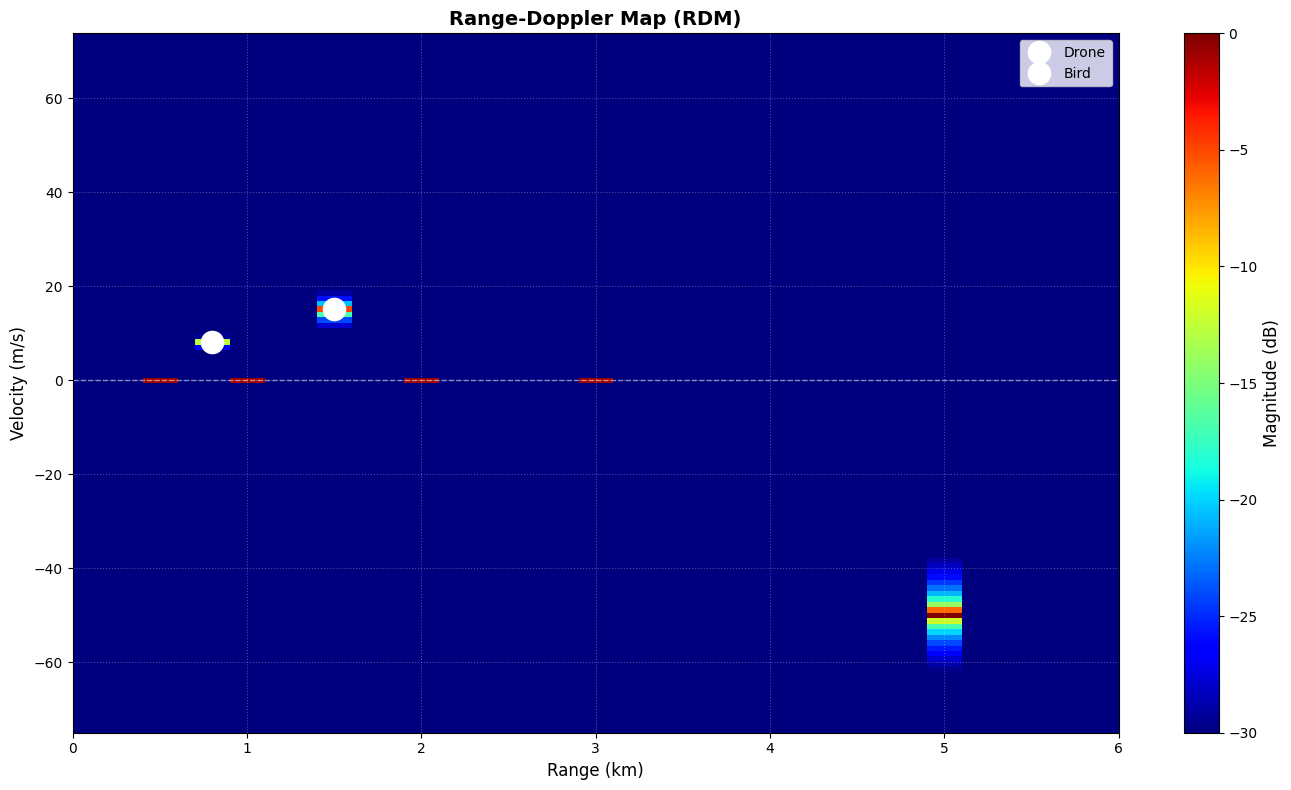


Radar Parameters:
  Range resolution: 1.00 m
  Velocity resolution: 1.17 m/s
  Max unambiguous range: 15.00 km
  Max unambiguous velocity: 75.00 m/s


In [ ]:
def scenario_multi_target():
    """
    Realistic counter-UAS scenario
    """
    # Initialize radar
    radar = PulseDopplerRadar(
        f_c=10e9,          # 10 GHz X-band
        PRF=10e3,          # 10 kHz
        bandwidth=150e6,   # 150 MHz
        num_pulses=128,    # 128 pulses in CPI
        samples_per_pulse=12000  # CHANGE from 4096 to 12000
    )

    # Add targets
    print("Creating scenario...")
    print("\nTargets:")

    # MOD: Stationary clutter - REDUCE
    # Stationary clutter (buildings, ground)
    for r in [500, 1000, 2000, 3000]:
        radar.add_target(range_m=r, velocity_ms=0, rcs=1.5)  # Medium strength

    # Moving targets
    radar.add_target(range_m=1500, velocity_ms=15, rcs=1.0)  # Drone
    radar.add_target(range_m=800, velocity_ms=8, rcs=0.4)    # Bird
    radar.add_target(range_m=5000, velocity_ms=-50, rcs=2.0) # Aircraft (strongest)


    print(f"\nDEBUG: data_matrix shape: {radar.data_matrix.shape}")
    print(f"DEBUG: data_matrix non-zero elements: {np.count_nonzero(radar.data_matrix)}")
    print(f"DEBUG: data_matrix max \"magnitude\": {np.max(np.abs(radar.data_matrix))}")

    # Add noise
    radar.add_noise(snr_db=60)

    # Generate RDM
    print("\nGenerating Range-Doppler Map...")
    rdm, range_axis, velocity_axis = radar.generate_rdm(window='Hamming')

    # DEBUG: Check RDM statistics - MOVE THIS INSIDE
    print(f"\nDEBUG RDM:")
    print(f"  RDM shape: {rdm.shape}")
    print(f"  RDM max: {np.max(rdm):.2e}")
    print(f"  RDM mean: {np.mean(rdm):.2e}")
    print(f"  Max position: {np.unravel_index(np.argmax(rdm), rdm.shape)}")

    # Find peaks in RDM
    rdm_flat = rdm.flatten()
    top_indices = np.argsort(rdm_flat)[-10:]  # Top 10 values
    #
    print(f"  Top 10 peak positions (doppler_bin, range_bin): ")
    for idx in top_indices[::-1]:
        pos = np.unravel_index(idx, rdm.shape)
        print(f"    {pos}: velocity={velocity_axis[pos[0]]:.1f} m/s, range={range_axis[pos[1]]:.1f} m, magnitude={rdm[pos]:.2e}")
    #
    # Visualize
    fig = radar.plot_rdm(rdm, range_axis, velocity_axis, range_max_km=6, dynamic_range_db=30)
    #
    # plt.savefig('/Users/amlanchatterjee/rdm_example.png', dpi=150, bbox_inches='tight')
    plt.show()

    # Print system parameters
    print("\nRadar Parameters:")
    print(f"  Range resolution: {radar.c/(2*radar.B):.2f} m")
    print(f"  Velocity resolution: {radar.wavelength*radar.PRF/(2*radar.M):.2f} m/s")
    print(f"  Max unambiguous range: {radar.c/(2*radar.PRF)/1000:.2f} km")
    print(f"  Max unambiguous velocity: {radar.wavelength*radar.PRF/4:.2f} m/s")

    return radar, rdm, range_axis, velocity_axis

# Run it
radar, rdm, range_axis, velocity_axis = scenario_multi_target()

---
# 4. Understanding the RDM: What You're Looking At

When you look at the RDM image:

## Axes
- **X-axis (horizontal):** Range (distance from radar)
- **Y-axis (vertical):** Velocity (positive = approaching, negative = receding)

## What You See

**Bright spots = targets**
- Position tells you range AND velocity simultaneously
- Brightness ∝ target strength (RCS)

**Vertical line at velocity = 0:**
- Stationary clutter (buildings, ground, trees)
- This is why we need MTI (Moving Target Indication) to filter it out

**Spots away from zero velocity:**
- Moving targets (drones, birds, aircraft, vehicles)
- Horizontal position = range
- Vertical position = velocity

## Resolution Limits

**Range resolution (can you separate two targets in range?):**
```
ΔR = c / (2 * B)

Example: B = 150 MHz → ΔR = 1 m
```

**Velocity resolution (can you separate two targets in velocity?):**
```
Δv = λ * PRF / (2 * M)

Example: λ = 3 cm, PRF = 10 kHz, M = 128
Δv = 0.03 * 10000 / (2 * 128) = 1.17 m/s
```

---
# 5. MTI: Moving Target Indication

## The Problem

Clutter (stationary returns) can be 40-60 dB stronger than moving targets!
- Ground returns
- Buildings
- Trees, vegetation

**They overwhelm the moving targets you care about.**

## The Solution: Clutter Filtering

**Simple approach: High-pass filter in Doppler dimension**
- Remove DC component (zero velocity)
- Keep only non-zero Doppler frequencies

```python
# After Range-FFT, before Doppler-FFT:
for each range bin:
    Remove mean across pulses (DC removal)
    Apply high-pass filter
```

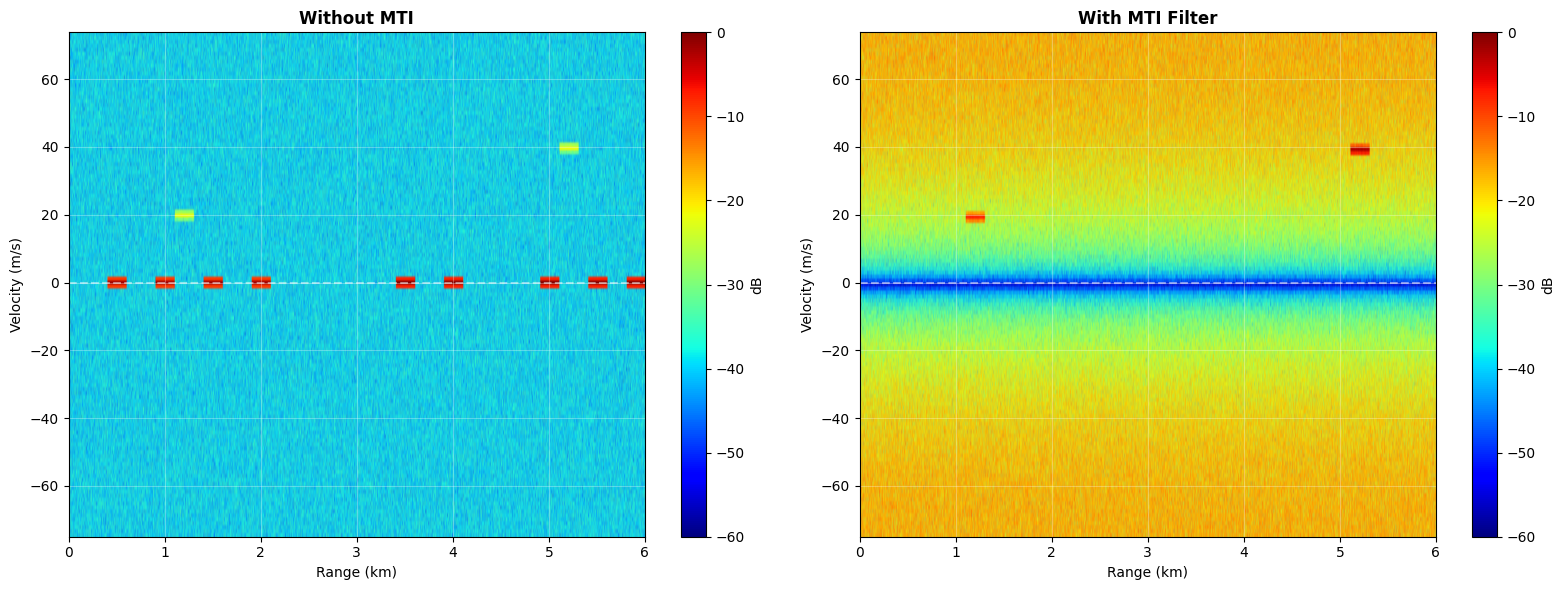

In [13]:
def apply_mti(radar, rdm_data):
    """
    Apply MTI filter - subtract consecutive pulses before FFT
    """
    # Diff in time domain (pulse dimension)
    data_mti = np.diff(radar.data_matrix, axis=0)

    # Same processing as generate_rdm()
    window_doppler = np.hamming(data_mti.shape[0])[:, np.newaxis]
    data_windowed = data_mti * window_doppler

    rdm_mti = fft(data_windowed, axis=0)
    rdm_mti = fftshift(rdm_mti, axes=0)

    return np.abs(rdm_mti)


# Example with MTI
def compare_with_without_mti():
    """
    Show effect of MTI filtering
    """
    # Create scenario
    radar = PulseDopplerRadar(num_pulses=128, samples_per_pulse=16000)

    # Strong clutter
    for r in [500, 1000, 1500, 2000]:
        radar.add_target(range_m=r, velocity_ms=0, rcs=10.0)  # Very strong

    # Use targets within detection range (like working version at ~5km)
    for r in [3500, 4000, 5000, 5500, 5900]:  # 5-6km range
        radar.add_target(range_m=r, velocity_ms=0, rcs=12.0)

    radar.add_target(range_m=5200, velocity_ms=40, rcs=1.0)

    # Weak moving target
    radar.add_target(range_m=1200, velocity_ms=20, rcs=1.0)  # Weak drone

    radar.add_noise(snr_db=10)

    # Generate RDMs
    rdm_no_mti, range_axis, velocity_axis = radar.generate_rdm()
    rdm_with_mti = apply_mti(radar, rdm_no_mti)

   # Plot comparison
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))

    range_bins = range_axis < 6000  # Show to 6km
    extent=[0, 6, velocity_axis[0], velocity_axis[-1]]

    # Without MTI
    rdm_db = 20 * np.log10(rdm_no_mti + 1e-10)
    rdm_db -= np.max(rdm_db)
    im = axes[0].imshow(
        rdm_db[:, range_bins],
        aspect='auto',
        extent=[0, 6, velocity_axis[0], velocity_axis[-1]],  # Match 6km
        cmap='jet',
        vmin=-60, vmax=0,
        origin='lower'
    )
    axes[0].set_xlabel('Range (km)')
    axes[0].set_ylabel('Velocity (m/s)')
    axes[0].set_title('Without MTI', fontweight='bold')
    axes[0].axhline(0, color='white', linestyle='--', alpha=0.5)
    axes[0].grid(True, alpha=0.3, color='white')
    plt.colorbar(im, ax=axes[0], label='dB')

    # With MTI - use SAME 60dB range as original
    rdm_mti_db = 20 * np.log10(rdm_with_mti + 1e-10)
    rdm_mti_db -= np.max(rdm_mti_db)  # Normalize to 0 dB

    im = axes[1].imshow(
        rdm_mti_db[:, range_bins],
        aspect='auto',
        extent=[0, 6, velocity_axis[0], velocity_axis[-1]], # Match 6km
        cmap='jet',
        vmin=-60, vmax=0,  # Same as original
        origin='lower'
    )
    axes[1].set_xlabel('Range (km)')
    axes[1].set_ylabel('Velocity (m/s)')
    axes[1].set_title('With MTI Filter', fontweight='bold')
    axes[1].axhline(0, color='white', linestyle='--', alpha=0.5)
    axes[1].grid(True, alpha=0.3, color='white')
    plt.colorbar(im, ax=axes[1], label='dB')

    plt.tight_layout()
    # plt.savefig('/Users/amlanchatterjee/mti_comparison.png', dpi=150, bbox_inches='tight')
    plt.show()

# Uncomment to run:
compare_with_without_mti()

---
# 6. Exercises & Experiments

Before moving to Part 3 (Micro-Doppler), try these:

## Exercise 1: Resolution Limits
Create two targets at:
- Same velocity (20 m/s) but ranges 1000m and 1001m
- Can you resolve them? What bandwidth do you need?

## Exercise 2: Velocity Ambiguity
Add a target with velocity 100 m/s (faster than max unambiguous)
- Where does it appear in the RDM?
- This is "Doppler folding" - understand it!

## Exercise 3: SNR Impact
Reduce SNR from 15 dB to 5 dB, then 0 dB
- At what point do targets disappear?
- This motivates CFAR detection (coming later)

## Exercise 4: CPI Length
Change num_pulses from 128 to 64, then 32
- How does velocity resolution change?
- Trade-off: resolution vs update rate

---

# Key Takeaways

✅ **RDM = 2D FFT** of pulse-Doppler data matrix  
✅ **Horizontal axis** = Range (from time delay)  
✅ **Vertical axis** = Velocity (from Doppler shift)  
✅ **MTI filters** remove stationary clutter  
✅ **Resolution** depends on bandwidth (range) and CPI length (velocity)  
✅ **Ambiguities** exist - max range and max velocity are limited  

---

## What's Next?

You now have the core RDM generation pipeline working. In **Part 3**, we'll add:

1. **Micro-Doppler signatures** - The rotor modulation that distinguishes drones from birds
2. **CFAR detection** - Automatic target detection in noise/clutter
3. **Target tracking** - Following targets across multiple CPIs

**Ready?** Run the examples above, play with parameters, then let me know what questions you have!